### Описание задания

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на Kaggle в рамках контеста [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

Модель должна определить является ли объект на изображении собакой.

Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from glob import glob
from matplotlib import pyplot as plt
from random import shuffle
from tensorflow.keras.applications import vgg16
%matplotlib inline

In [2]:
print(tf.__version__)
print(tf.executing_eagerly())

2.10.0
True


#### Необходимые функции

In [13]:
IMG_SIZE = (224, 224)

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    """Download original image"""
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=32):
    """Generator for downloading train data"""
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    """Generator for downloading test data"""
    while True:
        for path in files:
            yield np.array([load_image(path)])

#### Визуализация примеров для обучения

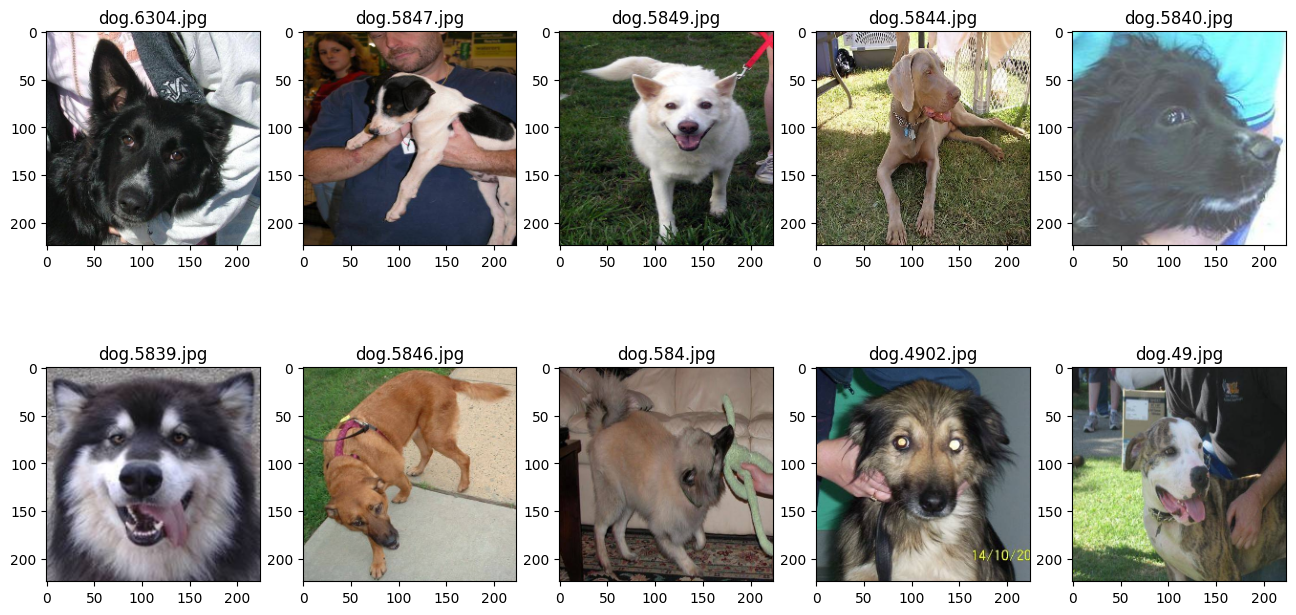

In [14]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Загрузка предобученной модели

In [15]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Добавление полносвязного слоя к преобученной моделе

In [17]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

Итоговая архитектура модели

In [18]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

### Обучение модели

In [19]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
test_size = 0.3

In [23]:
val_samples = int(test_size * len(train_files))

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], batch_size=32))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=10,
          epochs=10,
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 196s 20s/step - loss: 0.1769 - accuracy: 0.9375 - val_loss: 0.2679 - val_accuracy: 0.8750
Epoch 2/10
10/10 [==============================] - 259s 27s/step - loss: 0.2313 - accuracy: 0.9156 - val_loss: 0.2768 - val_accuracy: 0.8750
Epoch 3/10
10/10 [==============================] - 229s 23s/step - loss: 0.1395 - accuracy: 0.9438 - val_loss: 0.2738 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - 193s 19s/step - loss: 0.1909 - accuracy: 0.9281 - val_loss: 0.2544 - val_accuracy: 0.8750
Epoch 5/10
10/10 [==============================] - 187s 19s/step - loss: 0.1672 - accuracy: 0.9469 - val_loss: 0.2647 - val_accuracy: 0.9062
Epoch 6/10
10/10 [==============================] - 190s 19s/step - loss: 0.2440 - accuracy: 0.9062 - val_loss: 0.2661 - val_accuracy: 0.9062
Epoch 7/10
10/10 [==============================] - 191s 19s/step - loss: 0.1995 - accuracy: 0.9219 - val_loss: 0.2693 - val_accuracy: 0.9062
Epoch 

Обучение производилось в 2 этапа: 40 epoch и 10 epoch.

In [24]:
# model.save('cats-dogs-vgg16.hdf5')
model = keras.models.load_model('cats-dogs-vgg16.hdf5')

### Предсказание на test выборке

In [25]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 6728s 538ms/step


In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

### Подготовка данные для отправки на Kaggle

In [28]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

### Выводы:

На основе предобученной модели VGG16 с заменой в неё полносвязного слоя была построена модель для классификации изображения. По результатам на Kaggel был получен score: **0.17362**